In [1]:
from collections import Counter
import itertools
import logging

import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import colors
from unseal.hooks import Hook, HookedModel
from unseal.hooks.common_hooks import save_output

from datasets import get_dataset
from model import GrokkingTransformer
from utils import load_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cpu':
    logging.warning('No GPU found! Using CPU')

In [2]:
model_name = 'Single Layer ReLU'
ckpt, ckpt_dir = load_model(model_name)

model = GrokkingTransformer.load_from_checkpoint(ckpt).to(device)
model.eval()

key_layer = model.transformer[0].linear_net[0].weight
value_layer = model.transformer[0].linear_net[-1].weight

In [3]:
values = {219: value_layer[:, 219], 268: value_layer[:, 268], 446: value_layer[:, 446]}

for key1, key2 in itertools.combinations(values.keys(), r=2):
    print(f'angle({key1},{key2}) = {180/torch.pi * torch.arccos((values[key1] * values[key2]).sum() / values[key1].pow(2).sum().sqrt() / values[key2].pow(2).sum().sqrt()):.3f} deg')

angle(219,268) = 44.266 deg
angle(219,446) = 33.445 deg
angle(268,446) = 72.878 deg


In [4]:
# What's the distribution over key magnitudes for these three value vectors, over the whole dataset?
# Which inputs activate them the most?
dataset = torch.from_numpy(get_dataset(descr='minus', num_elements=97, data_dir='./data').data).to(device)

In [5]:
hooked_model = HookedModel(model)
hook = Hook("transformer->0->linear_net->2", save_output, key="save_key_magnitude")
hooked_model(dataset, hooks=[hook])
print('')

In [6]:
key_magnitude = hooked_model.save_ctx['save_key_magnitude']['output'][:,-1,[219,268,446]]
print(key_magnitude.shape)

torch.Size([9409, 3])


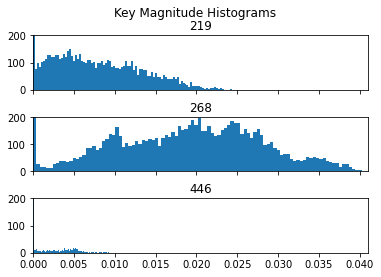

In [7]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, gridspec_kw={'hspace': 0.5})
for i in range(3):
    axes[i].hist(key_magnitude[:,i].detach().numpy(), bins=100)
    axes[i].set_title(f"{[219,268,446][i]}")
plt.xlim(0.000, 0.041)
plt.ylim(0,200)
plt.suptitle(f"Key Magnitude Histograms")
plt.show()

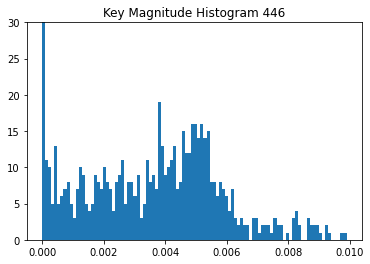

In [8]:
# look at the histogram for 446 individually
plt.figure()
plt.hist(key_magnitude[:,2].detach().numpy(), bins=100)
plt.ylim(0,30)
plt.title('Key Magnitude Histogram 446')
plt.show()

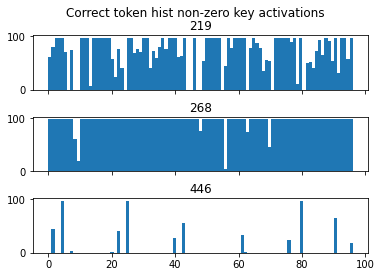

In [9]:
# get the data points to the largest 100 magnitudes


fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, gridspec_kw={'hspace': 0.5})
for i, key in enumerate([219,268,446]):
    axes[i].hist(dataset[key_magnitude[:,i] != 0][:,-1].cpu().numpy(), bins=97)
    axes[i].set_title(f"{key}")
plt.suptitle('Correct token hist non-zero key activations')
plt.show()

In [10]:
counts = list(Counter(dataset[key_magnitude[:,2] != 0][:,-1].cpu().numpy()).items())
counts = sorted(counts, key=lambda x: x[1])
print(f'Correct Token    Count')
for tup in counts:
    print(f'{tup[0]:12d} {tup[1]:10d}')

Correct Token    Count
          62          2
          20          2
           7          4
          96         19
          76         24
          40         27
          61         34
          22         41
           1         45
          43         56
          91         66
          80         97
          25         97
           4         97


In [11]:
orbit = [(80+21*i) % 97 for i in range(97)][:20]
for c in counts:
    if c[0] not in orbit:
        print(c[0])

76
40
61
22
1
43


In [13]:
print([(80+i*21)%97 for i in range(97)])

[80, 4, 25, 46, 67, 88, 12, 33, 54, 75, 96, 20, 41, 62, 83, 7, 28, 49, 70, 91, 15, 36, 57, 78, 2, 23, 44, 65, 86, 10, 31, 52, 73, 94, 18, 39, 60, 81, 5, 26, 47, 68, 89, 13, 34, 55, 76, 0, 21, 42, 63, 84, 8, 29, 50, 71, 92, 16, 37, 58, 79, 3, 24, 45, 66, 87, 11, 32, 53, 74, 95, 19, 40, 61, 82, 6, 27, 48, 69, 90, 14, 35, 56, 77, 1, 22, 43, 64, 85, 9, 30, 51, 72, 93, 17, 38, 59]
